# EPM Analysis
### Requires MossyEPM struct containing cell activity and behavior matrices for each mouse. Behavior is 30 fps, cell activity is 20 fps for drd73, drd77 and 10 fps for drd87, drd46

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style

style.use('seaborn')

%matplotlib inline

In [2]:
# TODO: Automate the column numbering
activity_column_names = ['neuron 1', 'neuron 2', 'neuron 3', 'neuron 4', 'neuron 5', 
                         'neuron 6', 'neuron 7', 'neuron 8', 'neuron 9', 'neuron 10']

behavior_column_names = ['Trial time', 'Recording time', 'X center', 'Y center', 'Area', 'Areachange', 
                         'Elongation', 'Distance moved', 'Velocity', 'In zone(Arena / center-point)',
                         'In zone(Open1 / center-point)', 'In zone(Open2 / center-point)',
                         'In zone(Closed1 / center-point)', 'In zone(Closed2 / center-point)',
                         'In zone(OpenArms / center-point)', 'In zone(ClosedArms / center-point)', 'Result 1']

activity_df = pd.read_csv('~/Hen_Lab/Mice/drd46_experiments/activity_drd46.csv', header=None)
behavior_df = pd.read_csv('~/Hen_Lab/Mice/drd46_experiments/behavior_drd46.csv', header=None)

# Save only every nth row in order to downsample behavior Dataframes from 30fps -> 10fps
ROW_MULTIPLE = 3
behavior_df.drop(behavior_df.index[[i for i in range(0, len(behavior_df.index)) if i % ROW_MULTIPLE != 0]], inplace=True)

# For the activity Dataframe, we Change column names to corresponding neuron names 
activity_df.columns = activity_column_names

# Change column names to the behavior column names found in the MossyEPM, MATLAB struct
behavior_df.columns = behavior_column_names

# Fix indexing after downsample
behavior_df.reset_index(drop=True, inplace=True)

# Make the behavior Dataframe indexed by Recording time
# behavior_df.set_index('Recording time', inplace=True)

# Make the behavior Dataframe and the activity Dataframe have the same amount of rows 
if len(behavior_df.index) > len(activity_df.index):
    diff = len(behavior_df.index) - len(activity_df.index)
    behavior_df = behavior_df[:-diff]
elif len(behavior_df.index) < len(activity_df.index):
    diff = len(activity_df.index) - len(behavior_df.index)
    activity_df = activity_df[:-diff]

# Define running frames
VELOCITY_CUTOFF = 4;

# Adds column to the end of the behavior Dataframe and make each cell in that column a 0 
# if the corresponding velocity < VELOCITY_CUTOFF or a 1 if the corresponding velocity >= VELOCITY_CUTOFF
behavior_df['Running frames'] = [1 if velocity > VELOCITY_CUTOFF else 0 for velocity in behavior_df['Velocity'].tolist()]

# Calculate rates by arm, running, and time period

# Divide session into this many bins
TIME_BIN_FACTOR = 3; 

"""
activity = EPM_activity.(mice{i});
behavior = EPM_behavior_ds.(mice{i});

# Rates for entire session
[AUCrates.(mice{i}), ~] = mc_epm_calc_beh_rates(behavior, activity, 'EPM');
AUCrates.(mice{i}) = 10 * AUCrates.(mice{i});

# AUCrates_binned = NaN;

bin_length = floor(size(activity, 1) / time_bin_factor);

for j = in range(0, TIME_BIN_FACTOR):
    start_frame = (j - 1) * bin_length + 1;
    end_frame = j * bin_length;
    [AUCrates_binned.(mice{i}){j}, AUCtotal_binned.(mice{i}){j}] = mc_epm_calc_beh_rates(behavior(start_frame:end_frame, :), activity(start_frame:end_frame, :), 'EPM');  

    # Multiply by frame rate to get rate in seconds
    AUCrates_binned.(mice{i}){j} = 10 * AUCrates_binned.(mice{i}){j}; 
    
    # Divide by bin_length to get total average total rate per bin
    # AUCtotal_binned.(mice{i}){j} = 10*AUCtotal_binned.(mice{i}){j} / bin_length;
    
    AUCtotal_binned_rate.(mice{i}){j} = 10 * sum(AUCtotal_binned.(mice{i}){j}(:, 1:3), 2) / bin_length; 

# AUCtotal_binned_rate.(mice{i}) = cell2mat(AUCtotal_binned_rate.(mice{i}));

# Create array with all cells by behavior over the whole session 
for i = 1:numel(mice)
    if i == 1:
        AUC_all_cells = AUCrates.(mice{i});
    else:
        AUC_all_cells = [AUC_all_cells; AUCrates.(mice{i})]

# Create array with all neurons for each time bin, irrespective of behavior
for i = 1:numel(mice):
    if i == 1:
        AUC_bin_all_cells = AUCtotal_binned_rate.(mice{i})
    else:
        AUC_bin_all_cells = [AUC_bin_all_cells; AUCtotal_binned_rate.(mice{i})]

# Calculate time bin averages and SEM per animal
for i = 1:numel(mice):
    AUC_all_cells_binned = AUCrates.rates_binned.(mice{i});
    AUC_bin_means(i,:) = mean(AUCtotal_binned_rate.(mice{i}));
    AUC_bin_SE(i,:) = std(AUCtotal_binned_rate.(mice{i}))/sqrt(size(AUCrates.(mice{i}),1));

# Store 10 col. averages per time bin (Nbins x 10)
for i = 1:numel(mice):
    for j in range(0, TIME_BIN_FACTOR):
        sum_closed(j) = sum_closed(j) + sum(AUCrates_binned.(mice{i}){j}(1), 2);
        sum_open(j) = sum_open(j) + sum(AUCrates_binned.(mice{i}){j}(2), 2);    
"""

# *** TEST ***
# activity_df
# behavior_df
result = pd.concat([activity_df, behavior_df], axis=1)
# result

In [3]:
run_vector = behavior_df['Running frames'][behavior_df['Running frames'] != 0].index.tolist()
no_run_vector = behavior_df['Running frames'][behavior_df['Running frames'] == 0].index.tolist()

run_sums = [activity_df[column][run_vector].sum() for column in activity_df]
no_run_sums = [activity_df[column][no_run_vector].sum() for column in activity_df]   

run_sums1 = [10 * run_sums[i] / len(run_vector) for i in range(0, len(run_sums))]
no_run_sums1 = [10 * no_run_sums[i] / len(no_run_vector) for i in range(0, len(no_run_sums))]
print(run_sums1)
print(no_run_sums1)

[1.412456799398948, 1.5293914350112698, 1.3462359128474832, 0.49829075882794893, 1.7421111945905334, 0.41998009015777615, 2.080439519158528, 3.1823384673178063, 3.5059083395942903, 2.7415135236664163]
[1.6788034535297103, 3.226457592686643, 1.2586244286439816, 1.055068308786186, 1.5058471305231087, 1.7695911630269172, 2.3405992889791776, 1.7558778567800915, 2.630134586084307, 1.261440832910107]


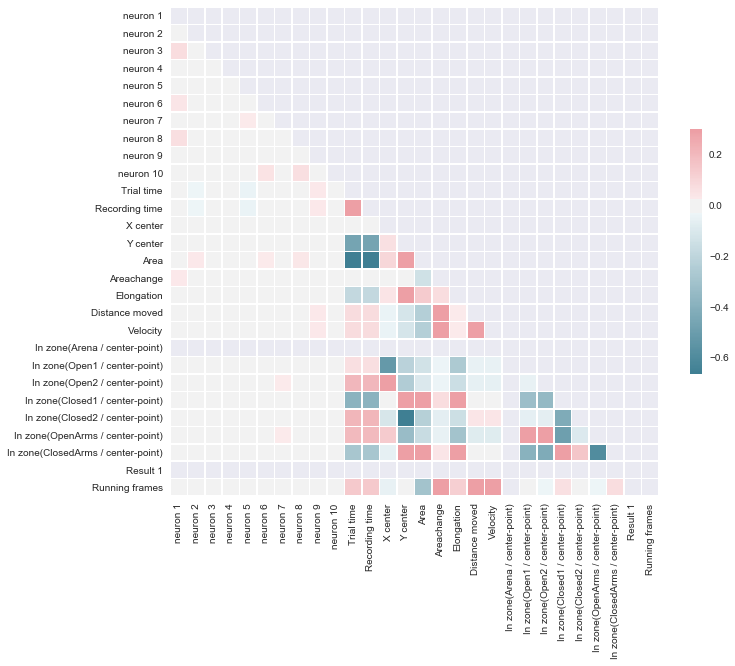

In [4]:
# Compute the correlation matrix
corr = result.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});